# Preparation 
## Append to path and import
In case gumpy is not installed as package, you may have to specify the path to the gumpy directory

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt 

import sys, os, os.path
sys.path.append('../..')

## import gumpy


This may take a while, as gumpy as several dependencies that will be loaded automatically

In [4]:
import numpy as np
import gumpy
import warnings
warnings.filterwarnings("ignore")

# Import data
To import data, you have to specify the directory in which your data is stored in. For the example given here, the data is in the subfolder ``../EEG-Data/Graz_data/data``. 
Then, one of the classes that subclass from ``dataset`` can be used to load the data. In the example, we will use the GrazB dataset, for which ``gumpy`` already includes a corresponding class. If you have different data, simply subclass from ``gumpy.dataset.Dataset``.

In [6]:
# First specify the location of the data and some 
# identifier that is exposed by the dataset (e.g. subject)
base_dir = '../..'
subject = 'S1'

# The next line first initializes the data structure. 
# Note that this does not yet load the data! In custom implementations
# of a dataset, this should be used to prepare file transfers, 
# for instance check if all files are available, etc.
data_low = gumpy.data.NST_EMG(base_dir, subject, 'low')
data_high = gumpy.data.NST_EMG(base_dir, subject, 'high') 

# Finally, load the dataset
data_low.load()
data_high.load()


The abstract class allows to print some information about the contained data. This is a commodity function that allows quick inspection of the data as long as all necessary fields are provided in the subclassed variant.

In [7]:
data_low.print_stats()
print('----------')
data_high.print_stats()

Data identification: NST_EMG-S1
EMG-data shape: (217613, 8)
Trials data shape:  (36,)
Labels shape:  (48,)
Total length of single trial:  10
Sampling frequency of EMG data: 512
Interval for motor imagery in trial:  [5, 10]
Classes possible:  [0. 1. 2. 3.]
----------
Data identification: NST_EMG-S1
EMG-data shape: (217618, 8)
Trials data shape:  (36,)
Labels shape:  (48,)
Total length of single trial:  10
Sampling frequency of EMG data: 512
Interval for motor imagery in trial:  [5, 10]
Classes possible:  [0. 1. 2. 3.]


# Signal Filtering

In [8]:
#bandpass
lowcut=20
highcut=255
#notch
f0=50
Q=50

flt_low = gumpy.signal.butter_bandpass(data_low, lowcut, highcut)
flt_low = gumpy.signal.notch(flt_low, cutoff=f0, Q=Q)

trialsLow = gumpy.utils.getTrials(data_low, flt_low)
trialsLowBg = gumpy.utils.getTrials(data_low, flt_low, True)

flt_high = gumpy.signal.butter_bandpass(data_high, lowcut, highcut)
flt_high = gumpy.signal.notch(flt_high, cutoff=f0, Q=Q)

trialsHigh = gumpy.utils.getTrials(data_high, flt_high)
trialsHighBg = gumpy.utils.getTrials(data_high, flt_high, True)



#  Data Visualization 

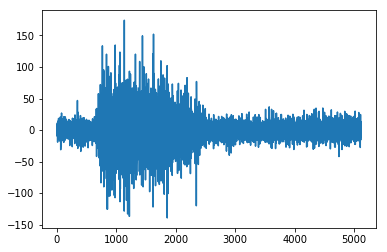

512

In [9]:
i=15
plt.figure()
plt.plot(flt_low[data_low.trials[i]: data_low.trials[i+1],4])
#plt.plot(data_low.raw_data[data_low.trials[i]: data_low.trials[i+1],2])
plt.show()
data_high.sampling_freq

# Features Extraction

In [9]:


window_size = 0.2
window_shift = 0.05

highRMSfeatures = gumpy.features.RMS_features_extraction(data_high, trialsHigh, window_size, window_shift)
highRMSfeaturesBg = gumpy.features.RMS_features_extraction(data_high, trialsHighBg, window_size, window_shift)
lowRMSfeatures = gumpy.features.RMS_features_extraction(data_high, trialsLow, window_size, window_shift)
lowRMSfeaturesBg = gumpy.features.RMS_features_extraction(data_high, trialsLowBg, window_size, window_shift)



# Constructing Classification arrays
X_tot = np.vstack((highRMSfeatures, lowRMSfeatures))
y_tot = np.hstack((np.ones((highRMSfeatures.shape[0])),
                     np.zeros((lowRMSfeatures.shape[0]))))
  
X_totSig = np.vstack((highRMSfeatures, highRMSfeaturesBg, lowRMSfeatures, lowRMSfeaturesBg))
# Normalizing the features
X_totSig = X_totSig/np.linalg.norm(X_totSig)

y_totSig = np.hstack((data_high.labels, 
                     data_low.labels))

X_totSig

array([[0.00317433, 0.00347712, 0.00351526, ..., 0.0009686 , 0.00128107,
        0.00107977],
       [0.00362845, 0.00595219, 0.00753056, ..., 0.00087038, 0.00078948,
        0.00062584],
       [0.00309323, 0.00401737, 0.00336045, ..., 0.0010687 , 0.00079988,
        0.00072598],
       ...,
       [0.00212149, 0.00193713, 0.0020841 , ..., 0.00049861, 0.0005653 ,
        0.00119055],
       [0.00195615, 0.00182604, 0.00189547, ..., 0.00057526, 0.00064521,
        0.00068972],
       [0.00162141, 0.00206098, 0.00338333, ..., 0.00065747, 0.00061476,
        0.00061072]])

In [12]:
labels=y_totSig
labels

array([2., 1., 2., 2., 1., 0., 1., 2., 0., 1., 0., 0., 2., 1., 2., 1., 0.,
       1., 1., 0., 0., 2., 0., 2., 1., 2., 0., 1., 2., 0., 0., 1., 1., 0.,
       2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 0., 1., 1.,
       0., 2., 2., 2., 2., 0., 0., 1., 1., 2., 1., 2., 0., 0., 0., 0., 2.,
       1., 2., 1., 1., 1., 1., 2., 2., 1., 1., 0., 0., 2., 2., 0., 0., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])

# Normalization of features 

In [13]:
features =X_totSig
labels =y_totSig

# normalize the data first
features = gumpy.signal.normalize(features, 'mean_std')
# let's see some statistics
print("""Normalized Data:
  Mean    = {:.3f}
  Min     = {:.3f}
  Max     = {:.3f}
  Std.Dev = {:.3f}""".format(
  np.nanmean(features),np.nanmin(features),np.nanmax(features),np.nanstd(features)
))

Normalized Data:
  Mean    = 0.000
  Min     = -2.636
  Max     = 5.390
  Std.Dev = 1.000


## Splitting data for training 
Now that we extracted features (and reduced the dimensionality), we can split the data for test and training purposes.

In [10]:

# gumpy exposes several methods to split a dataset, as shown in the examples:
if 1: 
    split_features = np.array(gumpy.split.normal(features, labels,test_size=0.2))
if 0: 
    n_splits=5
    split_features = np.array(gumpy.split.time_series_split(features, labels, n_splits)) 
if 0: 
    split_features = np.array(gumpy.split.normal(PCA, labels, test_size=0.2))
    
#ShuffleSplit: Random permutation cross-validator 
if 0: 
    split_features = gumpy.split.shuffle_Split(features, labels, n_splits=10,test_size=0.2,random_state=0)
    
# #Stratified K-Folds cross-validator
# #Stratification is the process of rearranging the data as to ensure each fold is a good representative of the whole   
if 0: 
    split_features = gumpy.split.stratified_KFold(features, labels, n_splits=3)
    
#Stratified ShuffleSplit cross-validator    
if 0: 
    split_features = gumpy.split.stratified_shuffle_Split(features, labels, n_splits=10,test_size=0.3,random_state=0)


# the functions return a list with the data according to the following example
X_train = split_features[0]
X_test = split_features[1]
Y_train = split_features[2]
Y_test = split_features[3]


array([[0.00241969, 0.0022337 , 0.0023087 , ..., 0.00084206, 0.00076152,
        0.00103709],
       [0.00316464, 0.00331519, 0.00239209, ..., 0.00194006, 0.0019764 ,
        0.00227144],
       [0.00433969, 0.00631524, 0.00652404, ..., 0.00064123, 0.00075638,
        0.00059114],
       ...,
       [0.00233438, 0.0031688 , 0.00322296, ..., 0.00297931, 0.00107865,
        0.00169824],
       [0.00252272, 0.00243595, 0.00187793, ..., 0.00090753, 0.00114431,
        0.00146587],
       [0.00252272, 0.00243595, 0.00187793, ..., 0.00090753, 0.00114431,
        0.00146587]])

In [ ]:
#SVM, RF, KNN, NB, LR, QLDA, LDA
from sklearn.cross_validation import cross_val_score
feature_idx, cv_scores, algorithm,sfs, clf = gumpy.features.sequential_feature_selector(X_train, Y_train, 'SVM',(6, 30), 3, 'SFFS')

feature=X_train[:,feature_idx]
# features=features[:,feature_idx]
scores = cross_val_score(clf, feature, Y_train, cv=3)
# scores = cross_val_score(clf, features, labels, cv=5)


print("Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
clf.fit(feature, Y_train)
feature1=X_test[:,feature_idx]
feature1.shape
clf.predict(feature1)
f=clf.score(feature1, Y_test)
print("Test Accuracy:",f )

# Gesture Classification

In [ ]:


if __name__ == '__main__':
    # Posture Classification
    classifiers = []
    Accuracy=[]
    Final_results = {}
    for model in gumpy.classification.available_classifiers:
        print (model)
        feature_idx, cv_scores, algorithm, sfs, clf = gumpy.features.sequential_feature_selector(features, labels,model,(6, 25), 3, 'SFFS')
        classifiers.append(model)
        Accuracy.append (cv_scores*100) 
        Final_results[model]= cv_scores*100
        print (Final_results)

## Force classification

In [ ]:
if __name__ == '__main__':
    # Posture Classification
    classifiers = []
    Accuracy=[]
    Final_results = {}
    for model in gumpy.classification.available_classifiers:
        print (model)
        feature_idx, cv_scores, algorithm = gumpy.features.sequential_feature_selector(X_tot, y_tot, model,(6, 25), 10, 'SFFS')
        classifiers.append(model)
        Accuracy.append (cv_scores*100) 
        Final_results[model]= cv_scores*100
print (Final_results)

## Classification without the feature selection method

In [ ]:
classifiers = []
Accuracy=[]
Final_results = {}
for model in gumpy.classification.available_classifiers:
    results, clf = gumpy.classify(model, X_train, Y_train, X_test, Y_test)
    print (model)
    classifiers.append(model)
    Accuracy.append (results.accuracy) 
    Final_results[model]= results.accuracy
print (Final_results)